# Flood Duration
Tralala

In [1]:
%run setup.ipynb
data_dir = Path('../data' )
output_dir = Path('../output') 

# load the data
SL_daily_max = xr.open_dataset(data_dir / 'SL_daily_max.nc')

In [2]:
# Extracting the necessary data
flood_day = SL_daily_max['flood_day']
time = SL_daily_max['time']
station_names = SL_daily_max['station_name'].values

# Convert time to pandas datetime
time = pd.to_datetime(time.values)

# Initialize a dictionary to hold results
flood_events = {}

# Loop through each station
for i, station in enumerate(station_names):
    station_flood_days = flood_day[:, i].values
    station_flood_days = pd.Series(station_flood_days, index=time)
    
    # Group by year
    station_flood_days_by_year = station_flood_days.groupby(station_flood_days.index.year)
    
    # Initialize list to hold all events for this station
    station_events = []
    
    for year, data in station_flood_days_by_year:
        flood_event_durations = []
        current_event_length = 0
        
        for day in data:
            if day:
                current_event_length += 1
            else:
                if current_event_length > 0:
                    flood_event_durations.append(current_event_length)
                current_event_length = 0
        
        # Append the last event if it was ongoing at the end of the year
        if current_event_length > 0:
            flood_event_durations.append(current_event_length)
        
        # Store the events for this year
        station_events.append({
            "year": year,
            "events": flood_event_durations
        })
    
    # Store the results for the station
    flood_events[station] = station_events

Text(0.04, 0.5, 'Duration (days)')

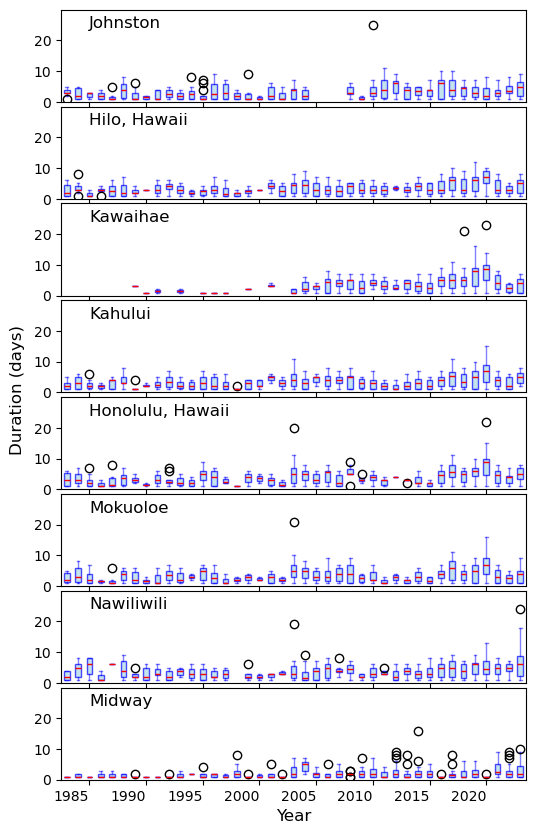

In [3]:
# Configure the plot grid with larger station names

# Extract unique years from the dataset, sorted for plotting
years = sorted({year_data["year"] for station_events in flood_events.values() for year_data in station_events})

# Define the number of stations and 5-year interval ticks
num_stations = len(station_names)
five_year_ticks = [year for year in years if year % 5 == 0]

# Create subplots: one per station, sharing the x-axis
fig, axes = plt.subplots(nrows=num_stations, ncols=1, figsize=(6, 10), sharex=True)
plt.subplots_adjust(hspace=0.05)  # Decrease hspace value to bring subplots closer

# Generate boxplots for each station
for ax, station in zip(axes, station_names):
    yearly_durations = {year: [] for year in years}

    # Gather flood event durations per year for the current station
    for year_data in flood_events[station]:
        yearly_durations[year_data["year"]].extend(year_data["events"])

    # Prepare the boxplot data
    boxplot_data = [yearly_durations[year] for year in years]

    # Create the boxplot with customized aesthetics
    ax.boxplot(
        boxplot_data,
        positions=range(len(years)),
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='blue', alpha=0.7),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='blue', alpha=0.5),
        capprops=dict(color='blue', alpha=0.5)
    )
    ax.set_ylim(0, 30)
    # Label each subplot with the station name
    ax.text(2, ax.get_ylim()[1] * 0.8, station, fontsize=12, ha='left', color='black')
    ax.set_yticks(range(0, 26, 10))
    ax.set_yticklabels(range(0, 26, 10),fontsize=10)
    

# Remove x-axis labels from all but the last subplot
for ax in axes[:-1]:
    ax.set_xticks([])

# Set x-ticks at 5-year intervals on the last subplot
axes[-1].set_xticks([years.index(year) for year in five_year_ticks])
axes[-1].set_xticklabels(five_year_ticks, ha='right', fontsize=10)
axes[-1].set_xlabel('Year', fontsize=12)

# Add a single y-axis label for the entire figure
fig.text(0.04, 0.5, 'Duration (days)', va='center', rotation='vertical', fontsize=12)



In [4]:
# load hourly data
hourly_data = xr.open_dataset(data_dir / 'SL_hourly_data.nc')

In [5]:
def get_flood_ds(hourly_data = hourly_data, threshold=30):
    flood_hour = (hourly_data.sea_level_MHHW.values > threshold)
    flood_hour
    flood_hour = np.transpose(flood_hour)
    flood_hour_df = pd.DataFrame(flood_hour, index = hourly_data.time.values, columns = hourly_data.record_id.values)

    # get sea level data where flood_hour is True

    flood_data = hourly_data.sea_level_MHHW.where(flood_hour.T)
    flood_data_df = pd.DataFrame(flood_data.T-threshold, index = hourly_data.time.values, columns = hourly_data.record_id.values)

    # Find indices of flood events, and the duration of each event for record id = 57
    # Initialize a dictionary to store the durations
    flood_durations = {}
    flood_heights = {}


    df_flood = flood_hour_df 

    # Loop through each sensor column
    for column in flood_hour_df.columns:
        flood_durations[column] = []
        flood_heights[column] = []

        # Find the indices where flooding starts and ends
        flood_events = df_flood[column].ne(df_flood[column].shift()).cumsum()

        # Group by the flood event indices, filtering out False events
        for event_id, group in df_flood.groupby(flood_events):
            if group[column].iloc[0]:  # Only consider True (flood) events
                start_time = group.index.min()
                end_time = group.index.max()
                duration = end_time - start_time 
                # round to nearest hour
                duration = np.round(duration.total_seconds() / 3600) + 1
                flood_durations[column].append((start_time, duration))
                height = flood_data_df.loc[start_time:end_time, column].max() # max height
                flood_heights[column].append((start_time, height))

    # make dataframe from dictionary
    # Assuming flood_durations and hourly_data are already defined

    # Initialize an empty list to store DataArrays
    data_arrays = []

    # Loop through each record_id and create a DataArray
    for record_id in hourly_data.record_id.values:
        flood_durations_df = pd.DataFrame(flood_durations[record_id])
        flood_durations_df.columns = ['time', 'duration']

        flood_heights_df = pd.DataFrame(flood_heights[record_id])   
        flood_heights_df.columns = ['time', 'height']

        # Merge the two DataFrames on 'time'
        merged_df = pd.merge(flood_durations_df, flood_heights_df, on='time')

        # Create a DataArray with both 'duration' and 'height'
        flood_data_da = xr.DataArray(
            merged_df[['duration', 'height']].values,
            dims=['time', 'variable'],
            coords={'time': merged_df.time.values, 'variable': ['duration', 'height'], 'record_id': record_id}
        )

        data_arrays.append(flood_data_da)


    # Combine all DataArrays into a single Dataset
    flood_data_ds = xr.concat(data_arrays, dim='record_id')

    # Convert to Dataset
    flood_data_ds = flood_data_ds.to_dataset(dim='variable')

    # make storm time by shifting time by 4 months, such that May 1st is the start of the storm season
    # Convert the time values to pandas DatetimeIndex
    time_values = pd.to_datetime(flood_data_ds.time.values)
    
    # Jan 1 should be the equivalent of May 1
    shifted_time_values = time_values + pd.DateOffset(months=4)
    
    #remove anything in 1982
    shifted_time_values = shifted_time_values[shifted_time_values.year != 1982]
    
    
    # Assign the shifted time values back to the dataset
    flood_data_ds['time'] = shifted_time_values

    return flood_data_ds

In [6]:
flood_data_ds = get_flood_ds(hourly_data = hourly_data, threshold=30)

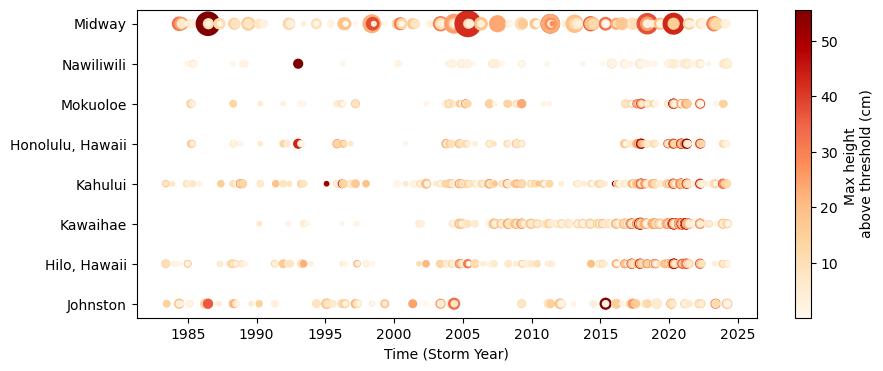

In [7]:
# scatterplot flood duration vs year
from matplotlib.colors import LinearSegmentedColormap

# make figure size small
plt.figure(figsize=(10,4))

# Create a custom color ramp and exclude the lightest shade
full_palette = sns.color_palette("Blues", n_colors=256)
# adjusted_heatmap_palette = full_palette[50:]  # Skip the lightest 50 shades

# Convert the adjusted palette to a colormap
# custom_palette = LinearSegmentedColormap.from_list("custom_blues", adjusted_heatmap_palette)
custom_palette = sns.color_palette("OrRd", as_cmap=True)


# selected_data['duration'] = selected_data['duration'].astype(float)
# flood_durations_ds['month'] = flood_durations_ds['month'].astype(float)

record_ids = flood_data_ds['record_id'].values
station_names = hourly_data['station_name'].sel(record_id=record_ids).values

for i, record_id in enumerate(record_ids):
    # Select data for the current record_id and drop NaNs
    selected_data = flood_data_ds.sel(record_id=record_id).dropna(dim='time')
    
    # Ensure 'duration' is numeric
    selected_data['duration'] = selected_data['duration'].astype(float)
    
    # Plot each station's data on a different y-coordinate
    scatter = plt.scatter(selected_data['time'], [i + 1] * len(selected_data['time']), s=10 * selected_data['duration'], c=selected_data['height'], cmap=custom_palette)

plt.xlabel('Time (Storm Year)')
plt.yticks(range(1, len(record_ids) + 1), hourly_data['station_name'].sel(record_id=record_ids).values)  # Set y-ticks to show station labels
plt.colorbar(scatter, label='Max height \nabove threshold (cm)')

# show the colorbar

In [8]:
# scatter plot height vs duration for each station
# make figure size small
from scipy.stats import gaussian_kde

def plot_flood_duration_vs_height(flood_data_ds, station_names):
    # Create figure and subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)  # 2 rows, 4 columns

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each station
    for i, record_id in enumerate(record_ids):
        # Select data for the current record_id and drop NaNs
        selected_data = flood_data_ds.sel(record_id=record_id).dropna(dim='time')

        # Ensure 'duration' is numeric
        selected_data['duration'] = selected_data['duration'].astype(float)

        # Extract year and apply jitter to duration for better visualization
        jitter_duration = selected_data['duration'] + np.random.uniform(-0.1, 0.1, size=selected_data['duration'].size)

        # Calculate point density
        xy = np.vstack([jitter_duration, selected_data['height']])
        z = gaussian_kde(xy)(xy)

        # Plot each station's data on its respective subplot, using the density (z) as color
        scatter = axes[i].scatter(jitter_duration, selected_data['height'], c=z, cmap='plasma', s=20)

        # # Set labels for each subplot
        axes[i].set_title(station_names[i], fontsize=8)
        # axes[i].set_xlabel('Duration (hours)')
        # axes[i].set_ylabel('Max height above threshold (cm)')

        # set x and y limits
        axes[i].set_xlim(0, 10)
        axes[i].set_ylim(0, 30)

    # Add a common colorbar
    cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', label='Density')

    # Set custom ticks and labels for the colorbar
    cbar.set_ticks([np.min(z), np.mean(z), np.max(z)])
    cbar.set_ticklabels(['Sparse', 'Moderate', 'Dense'], rotation=90,verticalalignment='center',fontsize=8)  # Custom labels

    # add x and y labels
    fig.text(0.45, -0.01, 'Duration (hours)', ha='center', fontsize=12)
    fig.text(0.05, 0.5, 'Max height above threshold (cm)', va='center', rotation='vertical', fontsize=12)


From the previous plots, it is clear that Midway is experiencing more frequent flooding, but less intense. Is this a remove-the-trend thing? 

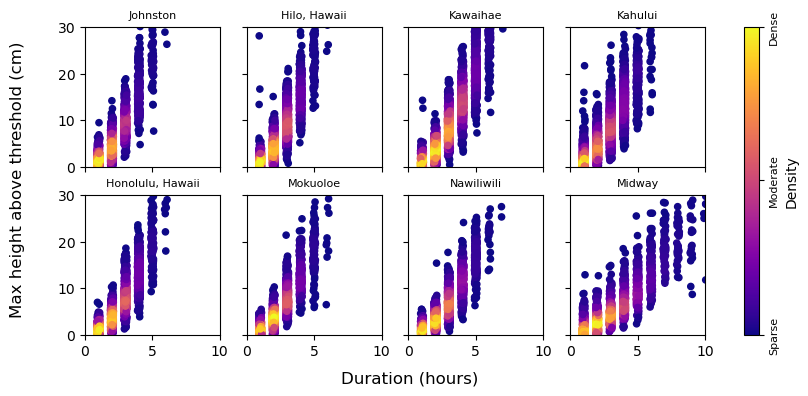

In [9]:
flood_data_30 = get_flood_ds(hourly_data=hourly_data,threshold=30)
flood_data_15 = get_flood_ds(hourly_data=hourly_data,threshold=15)
plot_flood_duration_vs_height(flood_data_15, station_names)

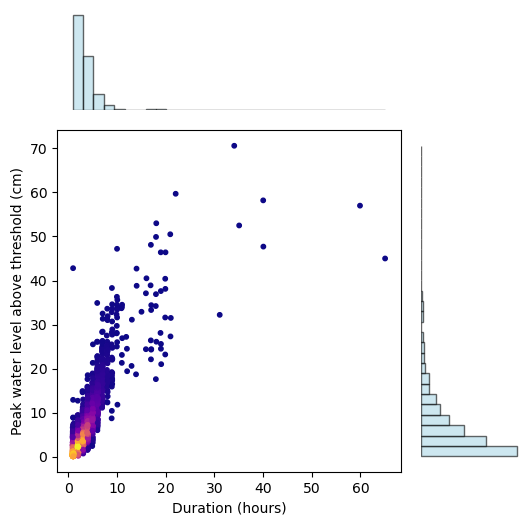

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec

# Example data for one station (you can adjust this to loop through your stations)
record_id = 50
selected_data = flood_data_15.sel(record_id=record_id).dropna(dim='time')
selected_data['duration'] = selected_data['duration'].astype(float)
jitter_duration = selected_data['duration'] + np.random.uniform(-0.1, 0.1, size=selected_data['duration'].size)

# Calculate point density for color mapping
xy = np.vstack([jitter_duration, selected_data['height']])
z = gaussian_kde(xy)(xy)

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(4, 4, figure=fig)

# Create scatter plot in the center
ax_main = fig.add_subplot(gs[1:4, 0:3])
scatter = ax_main.scatter(jitter_duration, selected_data['height'], c=z, cmap='plasma', s=10)
ax_main.set_xlabel('Duration (hours)')
ax_main.set_ylabel('Peak water level above threshold (cm)')

# Add colorbar to scatter plot
# cbar = fig.colorbar(scatter, ax=ax_main, orientation='vertical', label='Density')
# cbar.set_ticks([np.min(z), np.mean(z), np.max(z)])
# cbar.ax.set_yticklabels(['Sparse', 'Moderate', 'Dense'], rotation=90, verticalalignment='center')

# Create top histogram for duration
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(jitter_duration, bins=30, color='lightblue', alpha=0.6, edgecolor='black')
ax_histx.axis('off')  # Hide axes for cleaner look

# Create side histogram for height
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(selected_data['height'], bins=30, orientation='horizontal', color='lightblue', alpha=0.6, edgecolor='black')
ax_histy.axis('off')  # Hide axes for cleaner look

# Adjust layout to fit everything nicely
# plt.tight_layout()

# Show plot
plt.show()

In [11]:
time = selected_data['time']

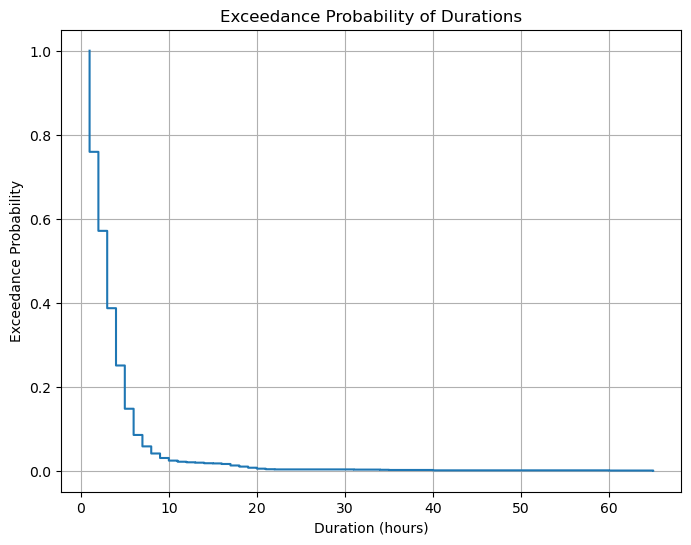

In [12]:
# Durations
sorted_durations = np.sort(selected_data['duration'])
exceedance_prob_duration = 1.0 - np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

plt.figure(figsize=(8,6))
plt.step(sorted_durations, exceedance_prob_duration, where='post')
plt.title('Exceedance Probability of Durations')
plt.xlabel('Duration (hours)')
plt.ylabel('Exceedance Probability')
plt.grid(True)



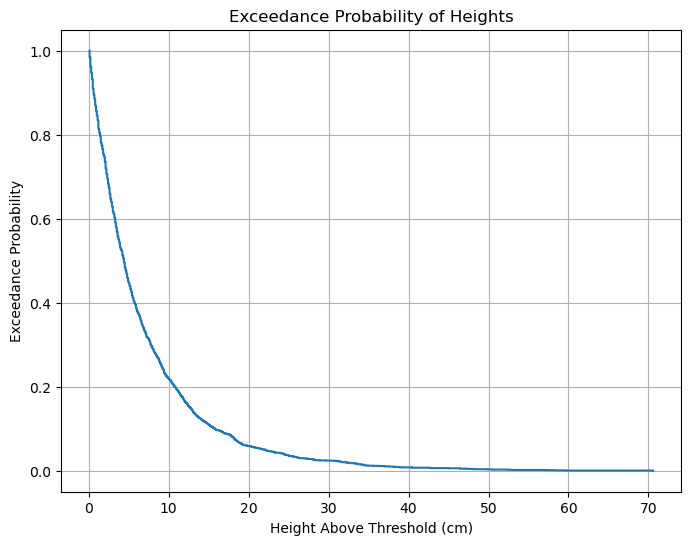

In [13]:
sorted_heights = np.sort(selected_data['height'])
exceedance_prob_height = 1.0 - np.arange(1, len(sorted_heights) + 1) / len(sorted_heights)

plt.figure(figsize=(8,6))
plt.step(sorted_heights, exceedance_prob_height, where='post')
plt.title('Exceedance Probability of Heights')
plt.xlabel('Height Above Threshold (cm)')
plt.ylabel('Exceedance Probability')
plt.grid(True)
plt.show()

In [14]:
selected_data = selected_data.to_dataframe()

In [15]:
# Define a function to categorize durations

# Define the ordered categories
duration_order = ['Short (1-2 hours)', 'Medium (3-6 hours)', 'Sustained (>6 hours)']

def categorize_duration(duration):
    if duration <= 2:
        return duration_order[0]
    elif 3 <= duration <= 6:
        return duration_order[1]
    else:
        return duration_order[2]



# Apply the function to create a new column
selected_data['duration_category'] = selected_data['duration'].apply(categorize_duration)


In [16]:
# Calculate the frequency of each category
category_counts = selected_data['duration_category'].value_counts()
total_events = len(data)

# Calculate the probability for each category
category_probs = category_counts / total_events

print("Frequency of Duration Categories:")
print(category_counts)

print("\nProbability of Duration Categories:")
print(category_probs)

Frequency of Duration Categories:
duration_category
Medium (3-6 hours)      1090
Short (1-2 hours)        963
Sustained (>6 hours)     191
Name: count, dtype: int64

Probability of Duration Categories:
duration_category
Medium (3-6 hours)      2.986301
Short (1-2 hours)       2.638356
Sustained (>6 hours)    0.523288
Name: count, dtype: float64


In [17]:
# Ensure the categories are ordered
category_counts = category_counts.reindex(duration_order)

# Compute cumulative counts from shortest to longest
cumulative_counts = category_counts[::-1].cumsum()[::-1]

# Compute survival probabilities
survival_probs = cumulative_counts / total_events

print("\nCumulative Counts by Duration Category:")
print(cumulative_counts)

print("\nSurvival Probabilities by Duration Category:")
print(survival_probs)


Cumulative Counts by Duration Category:
duration_category
Short (1-2 hours)       2244
Medium (3-6 hours)      1281
Sustained (>6 hours)     191
Name: count, dtype: int64

Survival Probabilities by Duration Category:
duration_category
Short (1-2 hours)       6.147945
Medium (3-6 hours)      3.509589
Sustained (>6 hours)    0.523288
Name: count, dtype: float64


In [18]:
# Calculate total observation period in years
total_years = (time.max()-time.min())/np.timedelta64(1, 's')/3600/24/365.25

# Calculate lambda
lambda_ = total_events / total_years

print(f"\nAverage number of events per year (lambda): {lambda_:.2f}")


Average number of events per year (lambda): 8.91


In [19]:
return_periods = 1 / (lambda_.item() * survival_probs)

# Display return periods
print("\nReturn Periods by Duration Category (in years):")
print(return_periods)


Return Periods by Duration Category (in years):
duration_category
Short (1-2 hours)       0.018252
Medium (3-6 hours)      0.031974
Sustained (>6 hours)    0.214440
Name: count, dtype: float64


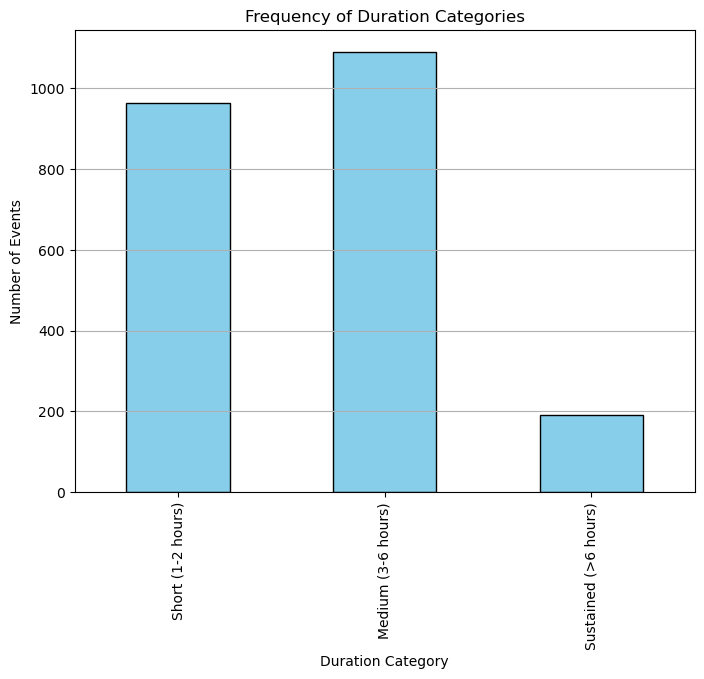

In [20]:
# Plot the frequency of each duration category
plt.figure(figsize=(8,6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Duration Categories')
plt.xlabel('Duration Category')
plt.ylabel('Number of Events')
plt.grid(axis='y')
plt.show()

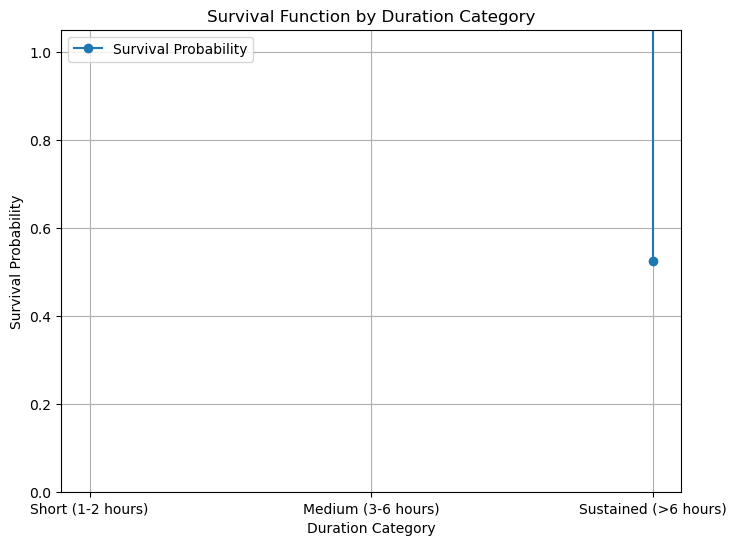

In [21]:
# Plot the survival function
plt.figure(figsize=(8,6))
plt.step(duration_order, survival_probs, where='post', marker='o', label='Survival Probability')
plt.title('Survival Function by Duration Category')
plt.xlabel('Duration Category')
plt.ylabel('Survival Probability')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# Group data by duration category
grouped_data = selected_data.groupby('duration_category')

In [23]:
# Create a dictionary to store GEV parameters for each category
gev_params = {}

for category, group in grouped_data:
    # Extract height data
    heights = group['height'].values
    
    # Fit GEV distribution
    c, loc, scale = genextreme.fit(heights)
    
    # Store parameters
    gev_params[category] = (c, loc, scale)

    print(f"GEV parameters for {category} category: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")

NameError: name 'genextreme' is not defined

In [337]:
# Define return periods of interest
return_periods = np.arange(2,100,2)  # in years

# Calculate the non-exceedance probabilities
probabilities = 1 - (1 / (np.array(return_periods) * lambda_.item()))

# Create a DataFrame to store return levels
return_levels_df = pd.DataFrame(index=return_periods, columns=duration_order)

for category in duration_order:
    if category not in gev_params:
        continue
    c, loc, scale = gev_params[category]
    # Calculate return levels for each return period
    return_levels = genextreme.ppf(probabilities, c, loc=loc, scale=scale)
    return_levels_df[category] = return_levels



Return Levels (Heights) for Each Duration Category and Return Period:
    Short (1-2 hours)  Medium (3-6 hours)  Sustained (>6 hours)
2            6.224795           15.970745             44.356114
4            8.666439           18.990545             51.617372
6           10.422973           20.836613             56.110459
8           11.845925           22.186103             59.420051
10          13.063648           23.256813             62.060692
12          14.139600           24.147761             64.267777
14          15.110475           24.912661             66.169604
16          15.999675           25.584035             67.844150
18          16.823164           26.183119             69.342502
20          17.592390           26.724573             70.700025
22          18.315882           27.218955             71.942253
24          19.000185           27.674133             73.088250
26          19.650448           28.096126             74.152641
28          20.270808           2

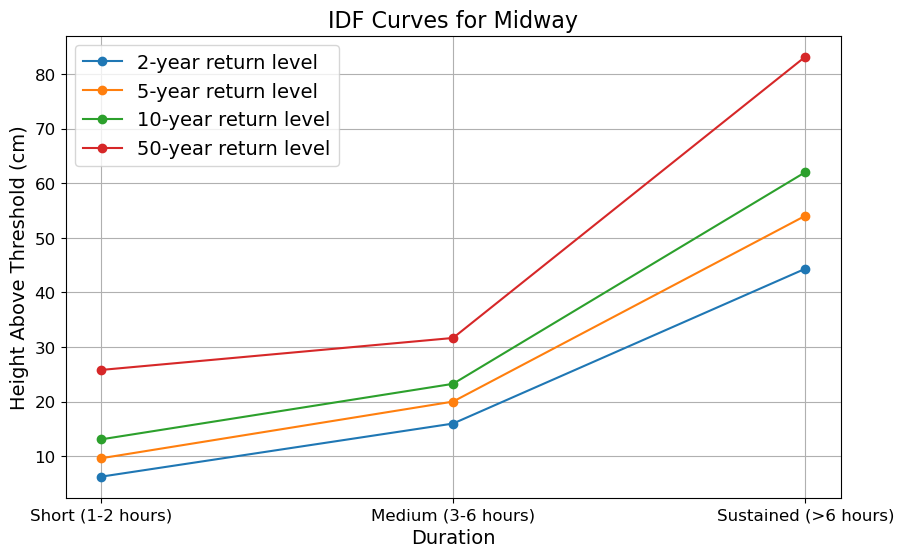

In [338]:
# Assume duration_order, gev_params, and lambda_ are predefined

return_periods_interest = [2, 5, 10, 50]  # in years



# Create an empty dict to store the return levels for the chosen return period
return_levels_by_period = {period: [] for period in return_periods_interest}

for return_period in return_periods_interest:
    # Calculate the non-exceedance probability for the chosen return period
    probability = 1 - (1 / (return_period * lambda_.item()))
    
    # Iterate over each duration category to calculate the return level for the chosen period
    for category in duration_order:
        if category not in gev_params:
            continue
        c, loc, scale = gev_params[category]
        
        # Calculate the return level for the specific return period
        return_level = genextreme.ppf(probability, c, loc=loc, scale=scale)
        return_levels_by_period[return_period].append(return_level)

# Plot the return level curve for the chosen return period (e.g., 2-year)
plt.figure(figsize=(10, 6))
for return_period in return_periods_interest:
    # Plot the return level curve for each return period
    plt.plot(duration_order, return_levels_by_period[return_period], marker='o', label=f'{return_period}-year return level')

plt.title(f'IDF Curves for' + ' ' + station_names[i])
plt.xlabel('Duration')
plt.ylabel('Height Above Threshold (cm)')
plt.grid(True)
plt.legend()

plt.show()

We can't do a curve here because the distribution of durations is very limited (at most stations). 

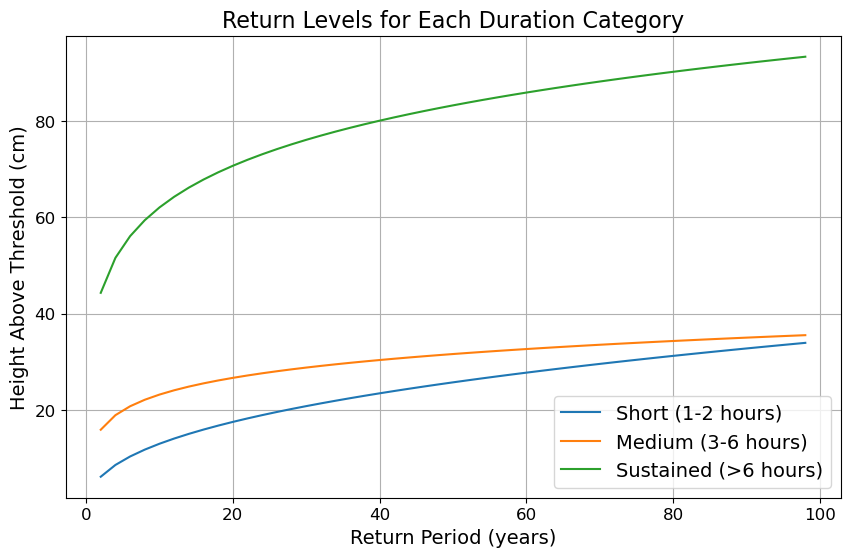

In [339]:
# Now plot the return levels for each duration category
plt.figure(figsize=(10, 6))

for category in duration_order:
    if category not in gev_params:
        continue
    c, loc, scale = gev_params[category]
    
    # Calculate the return levels for each return period
    return_levels = genextreme.ppf(1 - (1 / (np.array(return_periods) * lambda_.item())), c, loc=loc, scale=scale)
    
    # Plot the return levels for each duration category
    plt.plot(return_periods, return_levels,  label=category)

plt.title('Return Levels for Each Duration Category')
plt.xlabel('Return Period (years)')
plt.ylabel('Height Above Threshold (cm)')

plt.grid(True)
plt.legend()